Camera Location Identifier
==


In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset

from torchvision import transforms, datasets, models

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# pip install pretrainedmodels
import pretrainedmodels

import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [2]:
# pip install watermark
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,torch

CPython 3.7.2
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
matplotlib 3.0.2
torch 1.0.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 6
interpreter: 64bit


In [3]:
IMG_PATH = 'camera_relocalization_sample_dataset/images/'
CSV_PATH = 'camera_relocalization_sample_dataset/info.csv'

## Architecture / Transfer learning

In [4]:
alex_features = pretrainedmodels.alexnet()._features

In [5]:
def count_input_neuron(model, image_dim):
        return model(torch.rand(1, *(image_dim))).data.view(1, -1).size(1)

In [6]:
count_input_neuron(alex_features, (3, 299,299))

16384

In [7]:
class TransferModel(nn.Module):
    """Contructor for pretrained model use.
    
    Parameters
    ----------
    pre_model : model
        Preatrained model from `pretrainedmodels` package
    image_dim : tuple if ints
        tuple of the size of input image
    """
    
    def __init__(self, pre_model, image_dim):
        super().__init__()
        self.num_features_out = self.count_input_neuron(pre_model, image_dim)
        self.features = nn.Sequential(*pre_model.children())
        self.linear0 = nn.Linear(self.num_features_out, 4096)
        self.linear1 = nn.Linear(4096, 2048)
        
        self.pos = nn.Linear(2048, 3, bias=False)
        self.ori = nn.Linear(2048, 4, bias=False)

    
    def forward(self, x): 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear0(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.linear1(x))
        x = F.dropout(x, training=self.training)
#         x = x.view(x.size(0), -1)
        pos = self.pos(x)
        ori = self.ori(x)

        return pos, ori

    
    def count_input_neuron(self, model, image_dim):
        return model(torch.rand(1, *(image_dim))).data.view(1, -1).size(1)

In [8]:
inceptionV3 = models.inception_v3(pretrained=True)

In [9]:
class PoseNet(nn.Module):
    """ PoseNet using Inception V3 """
    def __init__(self, InceptionV3):
        super(PoseNet, self).__init__()
        self.base_model = InceptionV3

        self.Conv2d_1a_3x3 = InceptionV3.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = InceptionV3.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = InceptionV3.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = InceptionV3.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = InceptionV3.Conv2d_4a_3x3
        self.Mixed_5b = InceptionV3.Mixed_5b
        self.Mixed_5c = InceptionV3.Mixed_5c
        self.Mixed_5d = InceptionV3.Mixed_5d
        self.Mixed_6a = InceptionV3.Mixed_6a
        self.Mixed_6b = InceptionV3.Mixed_6b
        self.Mixed_6c = InceptionV3.Mixed_6c
        self.Mixed_6d = InceptionV3.Mixed_6d
        self.Mixed_6e = InceptionV3.Mixed_6e
        self.Mixed_7a = InceptionV3.Mixed_7a
        self.Mixed_7b = InceptionV3.Mixed_7b
        self.Mixed_7c = InceptionV3.Mixed_7c

        # Out 2
        self.pos = nn.Linear(2048, 3, bias=False)
        self.ori = nn.Linear(2048, 4, bias=False)

    def forward(self, x):
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        pos = self.pos(x)
        ori = self.ori(x)

        return pos, ori

## Dataset

In [10]:
class CameraDataset(Dataset):
    """Camera position dataset."""

    def __init__(self, csv_file, img_dir, transform=None):
        """
        Parameters
        ----------
        csv_file : string
            Path to the csv file with annotations.
        root_dir : string
            Directory with all the images.
        transform : callable, optional
            Optional transform to be applied
            on a sample.
        """

        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.dataframe['ImageFile'].at[idx])
        image = Image.open(img_name)
        coords = self.dataframe.iloc[idx, 3:10].values
        coords = np.array(coords, dtype=np.float32)

        if self.transform:
            image = self.transform(image)
            coords = torch.tensor(coords, dtype=torch.float)

        sample = {'image': image, 'coords': coords}

        return sample

Default pretrained inceptionv3 net requires input of 3-channels RGB image of the size (3, 299, 299).

In [11]:
class ConvertPILMode():
    """Converts PIL image to 
        one of the supported modes: 
        - `L` - 1 channel - (grayscale)
        - `RGB` - 3 channels
        - `RGBA` - 4 channels
        """
    
    def __init__(self, mode):
        self.mode = mode
    def __call__(self, pil_image):
        return pil_image.convert(mode=self.mode)

In [12]:
transform = transforms.Compose([
    ConvertPILMode(mode='RGB'),
    transforms.Resize((299,299)),
    transforms.ToTensor()
])

In [13]:
dataset = CameraDataset(CSV_PATH, IMG_PATH, transform=transform)

# Small dataset for experiments
small_ds_inds = np.random.choice(range(len(dataset)), size=int(len(dataset)*0.1),
                replace=False)
small_dataset = Subset(dataset, small_ds_inds)
dataset = small_dataset

We split dataset onto 3 subsets for training, validation and test

In [14]:
def train_val_holdout_split(dataset, ratios=[0.7,0.2,0.1]):
    """Return indices for subsets of the dataset.
    
    Parameters
    ----------
    dataset : torch.utils.data.Dataset
        Dataset made with class which inherits `torch.utils.data.Dataset`
    ratios : list of floats
        List of [train, val, holdout] ratios respectively. Note, that sum of 
        values must be equal to 1. (train + val + holdout = 1.0)
    
    """
    
    assert np.allclose(ratios[0] + ratios [1] + ratios[2], 1)
    train_ratio = ratios[0]
    val_ratio = ratios[1]
    test_ratio = ratios[2]

    df_size = len(dataset)
    train_inds = np.random.choice(range(df_size), 
                                  size=int(df_size*train_ratio),
                                  replace=False)
    val_test_inds = list(set(range(df_size)) - set(train_inds))
    val_inds = np.random.choice(val_test_inds,
                                size=int(len(val_test_inds)*val_ratio/(val_ratio+test_ratio)),
                                replace=False)

    test_inds = np.asarray(list(set(val_test_inds) - set(val_inds)), dtype='int')
    
    assert len(list(set(train_inds) - set(val_inds) - set(test_inds))) == len(train_inds)
    
    return train_inds, val_inds, test_inds

In [15]:
train_ids, val_ids, test_ids = train_val_holdout_split(dataset, ratios=[0.9,0.05,0.05])

train_sampler = SubsetRandomSampler(train_ids)
val_sampler = SubsetRandomSampler(val_ids)
test_sampler = Subset(dataset, test_ids) 

In [16]:
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_sampler)

## Loss

In [17]:
def custom_loss(pos_pred, ori_pred, pos_true, ori_true, beta=500):
    ori_true = F.normalize(ori_true)
    loss_pos = pos_pred - pos_true
    loss_ori = ori_pred - ori_true
    loss = loss_pos.norm() + beta * loss_ori.norm()
    return loss

In [18]:
class Loss(nn.Module):
    def __init__(self, device, beta):
        self.beta = beta
        self.device = device
    def __call__(self, pos_pred, ori_pred, pos_true, ori_true):
#         pos_true = pos_true.to(self.device)
#         ori_true = ori_true.to(device)
        ori_true = F.normalize(ori_true)
        loss_pos = pos_pred - pos_true
        loss_ori = ori_pred - ori_true
        loss = loss_pos.norm() + self.beta * loss_ori.norm()
        return loss

## Model Training

In [19]:
inceptionV3.aux_logits = False
posenet = PoseNet(inceptionV3)
alexnet = TransferModel(alex_features, (3, 299, 299))

# fine tuning
# for parameter in list(model.parameters())[:-2]:
#     parameter.requires_grad = False

loss_func =  Loss(device, beta=750)#Loss(device, beta=750) #nn.MSELoss()

In [20]:
def fit(net, epochs, loss_func, train_loader, val_loader, device):
    start_time = time.time()
    print(f'Start training {epochs} epochs:')
    optim = opt.Adam(net.parameters(), lr=0.0001)
    train_sum_loss = []
    val_sum_loss = []

    for epoch in range(epochs):
        train_loss = 0
        net.train()
        for i, batch in enumerate(train_loader):
            optim.zero_grad()

            img, coords = batch['image'].to(device), batch['coords'].to(device)
            pos_pred, ori_pred = net(img)
            pos_target, ori_target = coords[:, :3], coords[:, 3:] 
#             print(i, pos_pred, ori_pred.shape, pos_target, ori_target.shape)
            loss = loss_func(pos_pred, ori_pred, pos_target, ori_target)
#             print(loss)
            loss.backward()
            optim.step()
            train_loss += loss
        train_loss /= len(train_loader)
        if epoch % 1 != 0:
            print('Epoch: %04d Train loss: %.4f' % (epoch, train_loss.item()))

        if epoch % 1 == 0:
            net.eval()
            with torch.no_grad():
                val_loss = 0
                for batch in val_loader:
                    img, coords = batch['image'].to(device), batch['coords'].to(device)
                    pos_pred, ori_pred = net(img)
                    pos_target, ori_target = coords[:, :3], coords[:, 3:] 
                    val_loss += loss_func(pos_pred, ori_pred, pos_target, ori_target)
                val_loss /= len(val_loader)

                train_sum_loss.append(train_loss.item())
                val_sum_loss.append(val_loss.item())

            print('Epoch: %04d Train loss: %.4f | Val loss: %.4f' % (epoch, train_loss.item(), val_loss.item()))
    
    end_time = time.time()
    hours, rem = divmod(end_time-start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Finished in {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    return train_sum_loss, val_sum_loss

def test(net, test_lr):
    net.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            img, coords = batch['image'].to(device), batch['coords'].to(device)
            pos_pred, ori_pred = net(img)
            pos_target, ori_target = coords[:, :3], coords[:, 3:] 
            test_loss += loss_func(pos_pred, ori_pred, pos_target, ori_target)
        test_loss /= len(test_lr)
    return test_loss.item()

In [21]:
def to_cuda(model, device):    
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model)

    model = model.to(device)

to_cuda(posenet, device)
to_cuda(alexnet, device)

Using 2 GPUs
Using 2 GPUs


In [22]:
%%time
pos_tr, pos_val = fit(posenet, 30, loss_func, train_loader, val_loader, device)

Start training 30 epochs:
Epoch: 0000 Train loss: 1962.0824 | Val loss: 1745.6990
Epoch: 0001 Train loss: 1259.2808 | Val loss: 1565.7279
Epoch: 0002 Train loss: 1102.7433 | Val loss: 1042.3821
Epoch: 0003 Train loss: 1125.8831 | Val loss: 967.6781
Epoch: 0004 Train loss: 969.2721 | Val loss: 1040.1288
Epoch: 0005 Train loss: 888.9185 | Val loss: 925.1297
Epoch: 0006 Train loss: 915.7120 | Val loss: 827.5421
Epoch: 0007 Train loss: 800.8990 | Val loss: 824.9278
Epoch: 0008 Train loss: 803.3761 | Val loss: 1198.3632
Epoch: 0009 Train loss: 736.4291 | Val loss: 1006.3903
Epoch: 0010 Train loss: 678.0361 | Val loss: 1104.8918
Epoch: 0011 Train loss: 752.8188 | Val loss: 1221.1526
Epoch: 0012 Train loss: 717.1215 | Val loss: 1135.3064
Epoch: 0013 Train loss: 682.8262 | Val loss: 1235.9232
Epoch: 0014 Train loss: 565.7497 | Val loss: 1096.6757
Epoch: 0015 Train loss: 670.1803 | Val loss: 1287.8768
Epoch: 0016 Train loss: 647.3893 | Val loss: 1188.3864
Epoch: 0017 Train loss: 701.3444 | Val 

In [23]:
posenet_test = test(posenet, test_loader)
print('Test loss: {:.4f}'.format(posenet_test))

Test loss: 94.9991


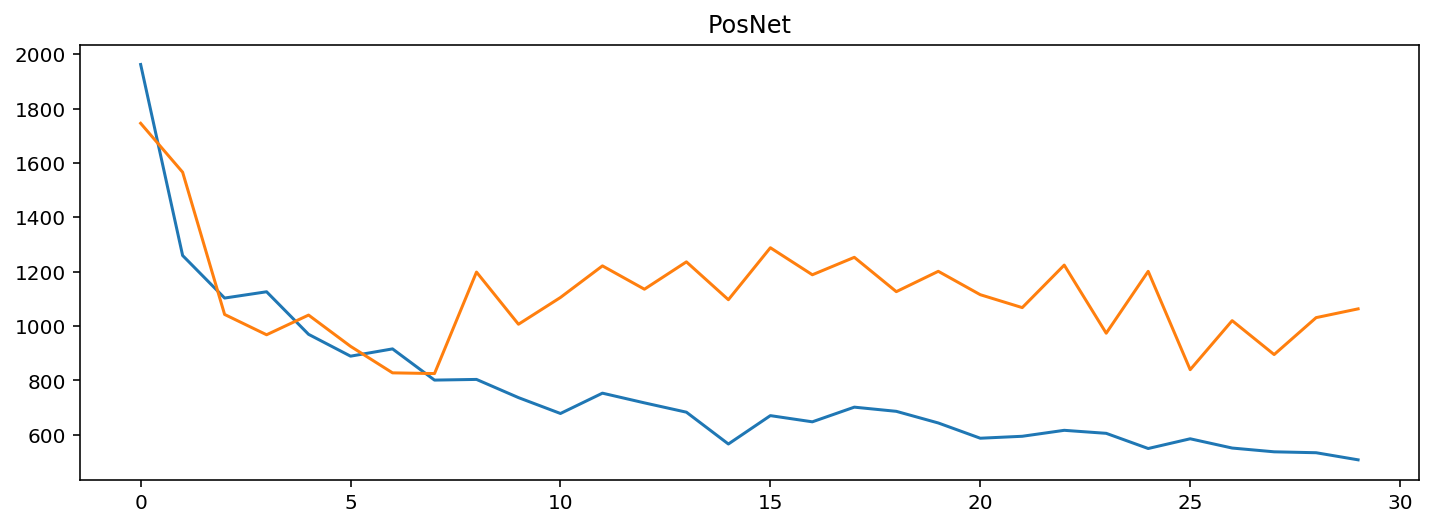

In [24]:
plt.figure(figsize=(12,4))
plt.plot(pos_tr, label='Train')
plt.plot(pos_val, label='Validation')
plt.title('PosNet');

In [25]:
%%time
loss_custom = custom_loss
al_tr, al_val = fit(alexnet, 50, loss_func, train_loader, val_loader, device)

Start training 50 epochs:
Epoch: 0000 Train loss: 1574.9375 | Val loss: 1615.0944
Epoch: 0001 Train loss: 1228.9703 | Val loss: 1212.7064
Epoch: 0002 Train loss: 954.1685 | Val loss: 1244.6528
Epoch: 0003 Train loss: 704.6237 | Val loss: 1246.7428
Epoch: 0004 Train loss: 620.3747 | Val loss: 1123.1044
Epoch: 0005 Train loss: 582.2372 | Val loss: 1031.7543
Epoch: 0006 Train loss: 488.4972 | Val loss: 1192.4379
Epoch: 0007 Train loss: 510.8408 | Val loss: 981.3312
Epoch: 0008 Train loss: 449.2331 | Val loss: 926.6846
Epoch: 0009 Train loss: 444.8989 | Val loss: 885.1039
Epoch: 0010 Train loss: 484.9142 | Val loss: 943.2405
Epoch: 0011 Train loss: 428.7126 | Val loss: 890.9655
Epoch: 0012 Train loss: 434.6173 | Val loss: 1001.0005
Epoch: 0013 Train loss: 426.1423 | Val loss: 975.7151
Epoch: 0014 Train loss: 417.4395 | Val loss: 770.2079
Epoch: 0015 Train loss: 422.4461 | Val loss: 961.0867
Epoch: 0016 Train loss: 378.7542 | Val loss: 1084.1292
Epoch: 0017 Train loss: 408.6379 | Val loss: 

In [26]:
alexnet_test = test(alexnet, test_loader)
print('Test loss: {:.4f}'.format(alexnet_test))

Test loss: 179.8907


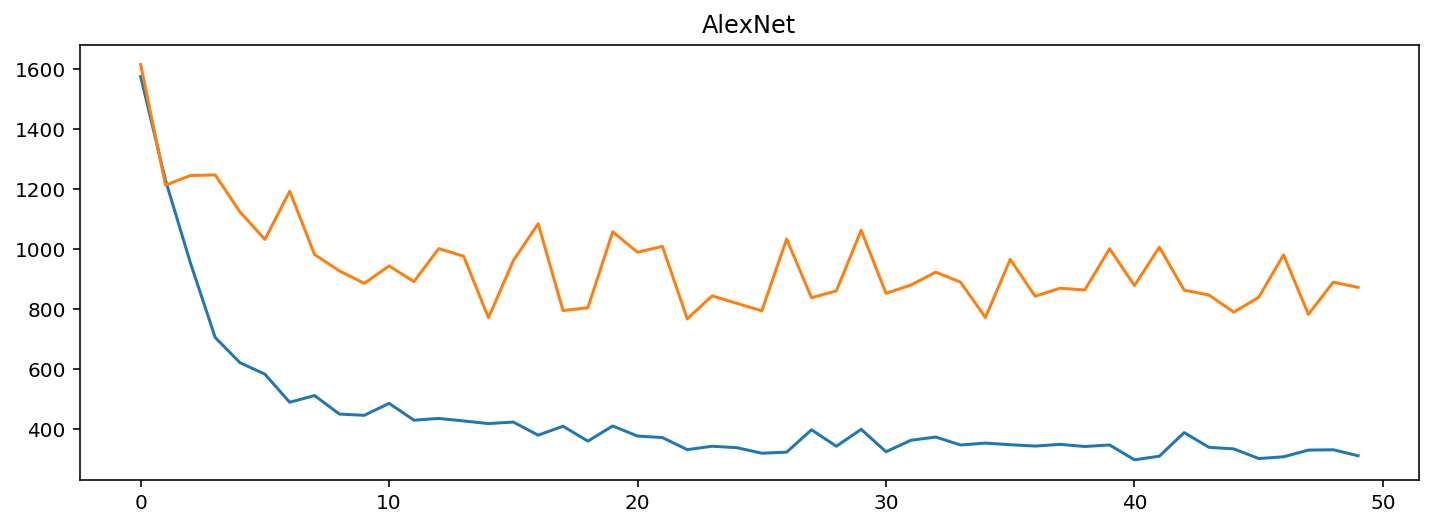

In [27]:
plt.figure(figsize=(12,4))
plt.plot(al_tr, label='Train')
plt.plot(al_val, label='Validation')
plt.title('AlexNet');